## Example - Site Drainage Model

This example models runoff quantity and quality in a 39
acre residential subdivision. It consists of 7 subcatchments
connected to a system of swales and culverts that convey
runoff to an outfall. A single pollutant, TSS, is modeled with
three land uses that produce different rates of buildup and
washoff. An antecedent dry period of 5 days is used to allow for
an initial buildup of TSS to occur. Rainfall time series data
for several 2-hour design storms of different return periods are
provided.

Here are some suggestions for running this example:

### 1. 
The model is set up to analyze the 2-yr 2-hour storm event over a six hour period using Dynamic Wave flow routing with a 15 second variable routing time step and a five minute reporting step. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import swmm_api
print(f'{swmm_api.__version__ = }')

swmm_api.__version__ = '0.4.59'


In [ ]:
from swmm_api import SwmmInput, SwmmOutput, SwmmReport
from swmm_api.output_file import OBJECTS, VARIABLES
from swmm_api.run_swmm import swmm5_run_epa, swmm5_run_progress
from swmm_api.run_swmm.run_temporary import swmm5_run_temporary

In [3]:
inp = SwmmInput('Site_Drainage_Model.inp')

### 2. 
Run the simulation and view the Status Report, taking note of the Continuity error.

In [4]:
with swmm5_run_temporary(inp.copy(), run=swmm5_run_epa, label='example_run_swmm') as res:
    out = res.out  # type: SwmmOutput
    rpt = res.rpt  # type: SwmmReport

In [5]:
rpt.get_simulation_info()

{'Analysis begun on': '  Mon Nov 18 12:27:15 2024',
 'Analysis ended on': '  Mon Nov 18 12:27:15 2024',
 'Total elapsed time': ' < 1 sec'}

In [6]:
rpt.available_parts

['Simulation Infos',
 'Version+Title',
 'Analysis Options',
 'Runoff Quantity Continuity',
 'Runoff Quality Continuity',
 'Flow Routing Continuity',
 'Quality Routing Continuity',
 'Time-Step Critical Elements',
 'Highest Flow Instability Indexes',
 'Most Frequent Nonconverging Nodes',
 'Routing Time Step Summary',
 'Subcatchment Runoff Summary',
 'Subcatchment Washoff Summary',
 'Node Depth Summary',
 'Node Inflow Summary',
 'Node Surcharge Summary',
 'Node Flooding Summary',
 'Outfall Loading Summary',
 'Link Flow Summary',
 'Flow Classification Summary',
 'Conduit Surcharge Summary',
 'Link Pollutant Load Summary']

In [7]:
rpt.print_raw_part('Runoff Quantity Continuity')
rpt.print_raw_part('Runoff Quality Continuity')

  **************************        Volume         Depth
  Runoff Quantity Continuity     acre-feet        inches
  **************************     ---------       -------
  Total Precipitation ......         2.358         0.978
  Evaporation Loss .........         0.000         0.000
  Infiltration Loss ........         1.011         0.420
  Surface Runoff ...........         1.285         0.533
  Final Storage ............         0.062         0.026
  Continuity Error (%) .....        -0.042
  **************************           TSS
  Runoff Quality Continuity            lbs
  **************************    ----------
  Initial Buildup ..........       913.850
  Surface Buildup ..........        38.133
  Wet Deposition ...........         0.000
  Sweeping Removal .........         0.000
  Infiltration Loss ........         0.000
  BMP Removal ..............         0.000
  Surface Runoff ...........       702.469
  Remaining Buildup ........       249.514
  Continuity Error (%) .....


### 3. 
Select some different summary output variables (e.g. subcatchment total Runoff, node Hours Flooded, link Max Degree Full) for viewing on the study area map. 

Use the Day/Time controls on the Map Browser to move back and forth through time.

In [8]:
from swmm_api.input_file.macros.plotting_map import init_empty_map_plot, add_subcatchments_labels, add_node_labels, add_link_map, add_node_map, add_subcatchment_map
import pandas as pd

sc_runoff = rpt.subcatchment_runoff_summary[f'Total_Runoff_10^6 {rpt.unit.VOL2}']
node_flooded_hrs = rpt.node_inflow_summary['Time of Max_Occurrence_days hr:min'] / pd.Timedelta(minutes=1)
link_full = rpt.link_flow_summary['Max/_Full_Flow']

_, ax = init_empty_map_plot()
add_link_map(ax, inp, values_dict=link_full.to_dict(), make_width_proportional=False, cmap='YlGn', colorbar_kwargs={'label':'Link Ratio Max Full in %'}, add_arrows=True)
add_subcatchment_map(ax, inp, values_dict=sc_runoff.to_dict(), cmap='YlGn', colorbar_kwargs={'label':f'SC Total Runoff in 10^6 {rpt.unit.VOL2}'})
add_node_map(ax, inp, make_size_proportional=True, cmap='Reds', values_dict=node_flooded_hrs.to_dict(), colorbar_kwargs={'label':'Node time max occurence in minutes'})
add_node_labels(ax, inp, size=5, y_offset=30)
add_subcatchments_labels(ax, inp, size=5, y_offset=40, color='black')

### 4. 
Then select some output time series variables, such as
   subcatchment Runoff, link flow, node TSS, to view on the map.
   Use the Day/Time controls on the Map Browser to move back and
   forth through time.

   (Note: you may need to edit the map legends so that their
    colors will capture the range of the variable being viewed.)


In [9]:
out.index

DatetimeIndex(['1998-01-01 00:01:00', '1998-01-01 00:02:00',
               '1998-01-01 00:03:00', '1998-01-01 00:04:00',
               '1998-01-01 00:05:00', '1998-01-01 00:06:00',
               '1998-01-01 00:07:00', '1998-01-01 00:08:00',
               '1998-01-01 00:09:00', '1998-01-01 00:10:00',
               ...
               '1998-01-01 05:51:00', '1998-01-01 05:52:00',
               '1998-01-01 05:53:00', '1998-01-01 05:54:00',
               '1998-01-01 05:55:00', '1998-01-01 05:56:00',
               '1998-01-01 05:57:00', '1998-01-01 05:58:00',
               '1998-01-01 05:59:00', '1998-01-01 06:00:00'],
              dtype='datetime64[ns]', length=360, freq='min')

In [10]:
from swmm_api.input_file.macros.plotting_map import *

link_flow = out.get_part(OBJECTS.LINK, None, VARIABLES.LINK.FLOW)
node_flooding = out.get_part(OBJECTS.NODE, None, VARIABLES.NODE.FLOODING)
sc_runoff = out.get_part(OBJECTS.SUBCATCHMENT, None, VARIABLES.SUBCATCHMENT.RUNOFF)

time = '1998-01-01 01:00'

_, ax = init_empty_map_plot()
add_link_map(ax, inp, values_dict=link_flow.loc[time].to_dict(), make_width_proportional=True, cmap='YlGn', colorbar_kwargs={'label':'Link Flow'})
add_subcatchment_map(ax, inp, values_dict=sc_runoff.loc[time].to_dict(), cmap='BuPu', colorbar_kwargs={'label':'SC Runoff'})
add_node_map(ax, inp, make_size_proportional=True, cmap='Reds', values_dict=node_flooding.loc[time].to_dict(), colorbar_kwargs={'label':'Node Flooding'})
add_node_labels(ax, inp, size=5, y_offset=30)
ax.set_title(f'Time: {time}')

Text(0.5, 1.0, 'Time: 1998-01-01 01:00')

### 5. 
Try generating some other types of reports, such as a time series plot and a profile plot.

<Axes: >

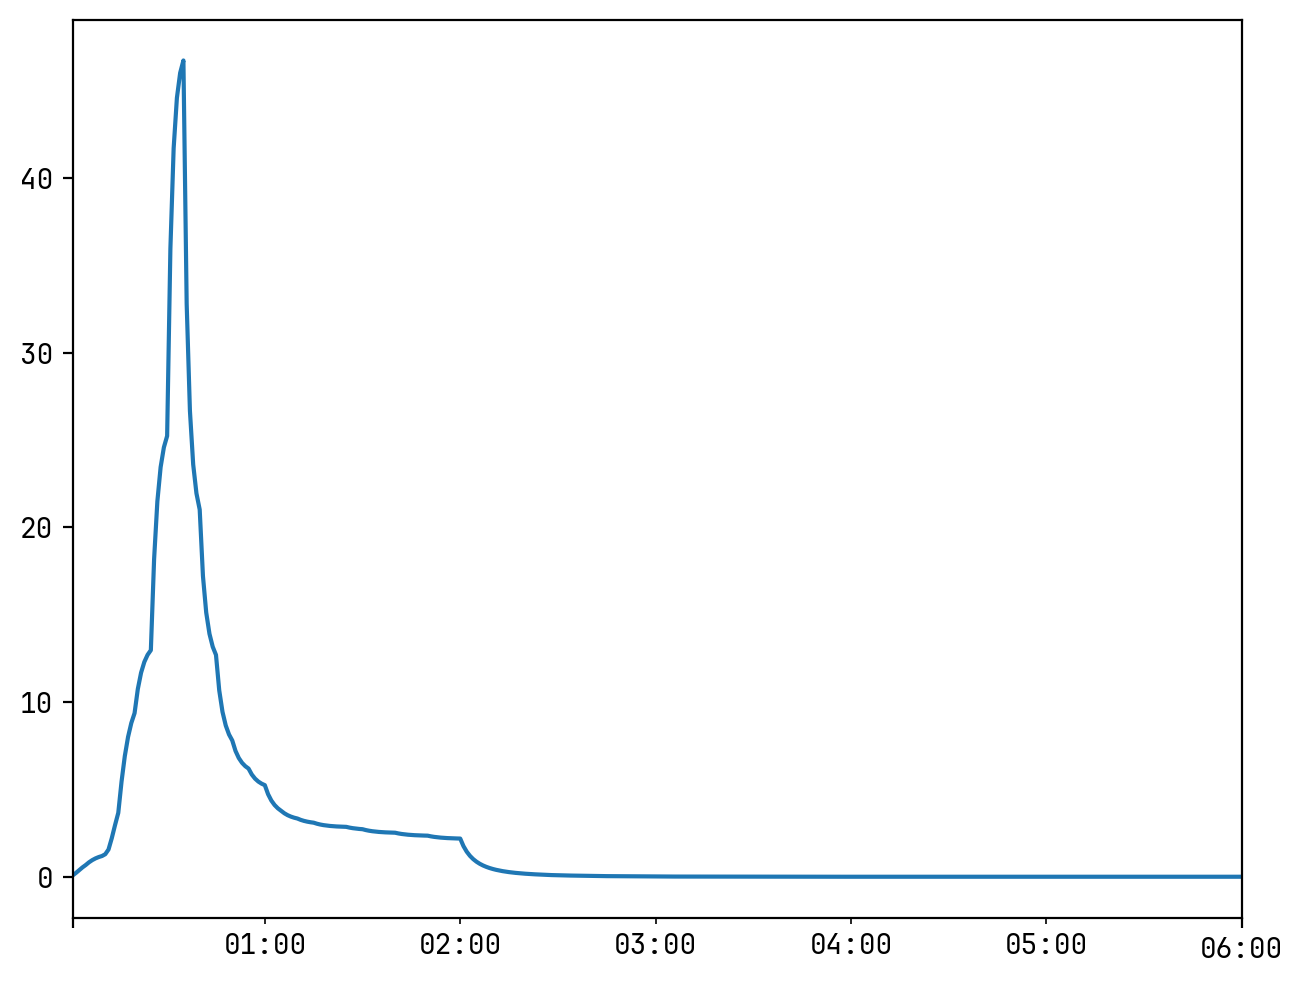

In [11]:
out.get_part(OBJECTS.SYSTEM, None, VARIABLES.SYSTEM.RUNOFF).plot()

<Axes: >

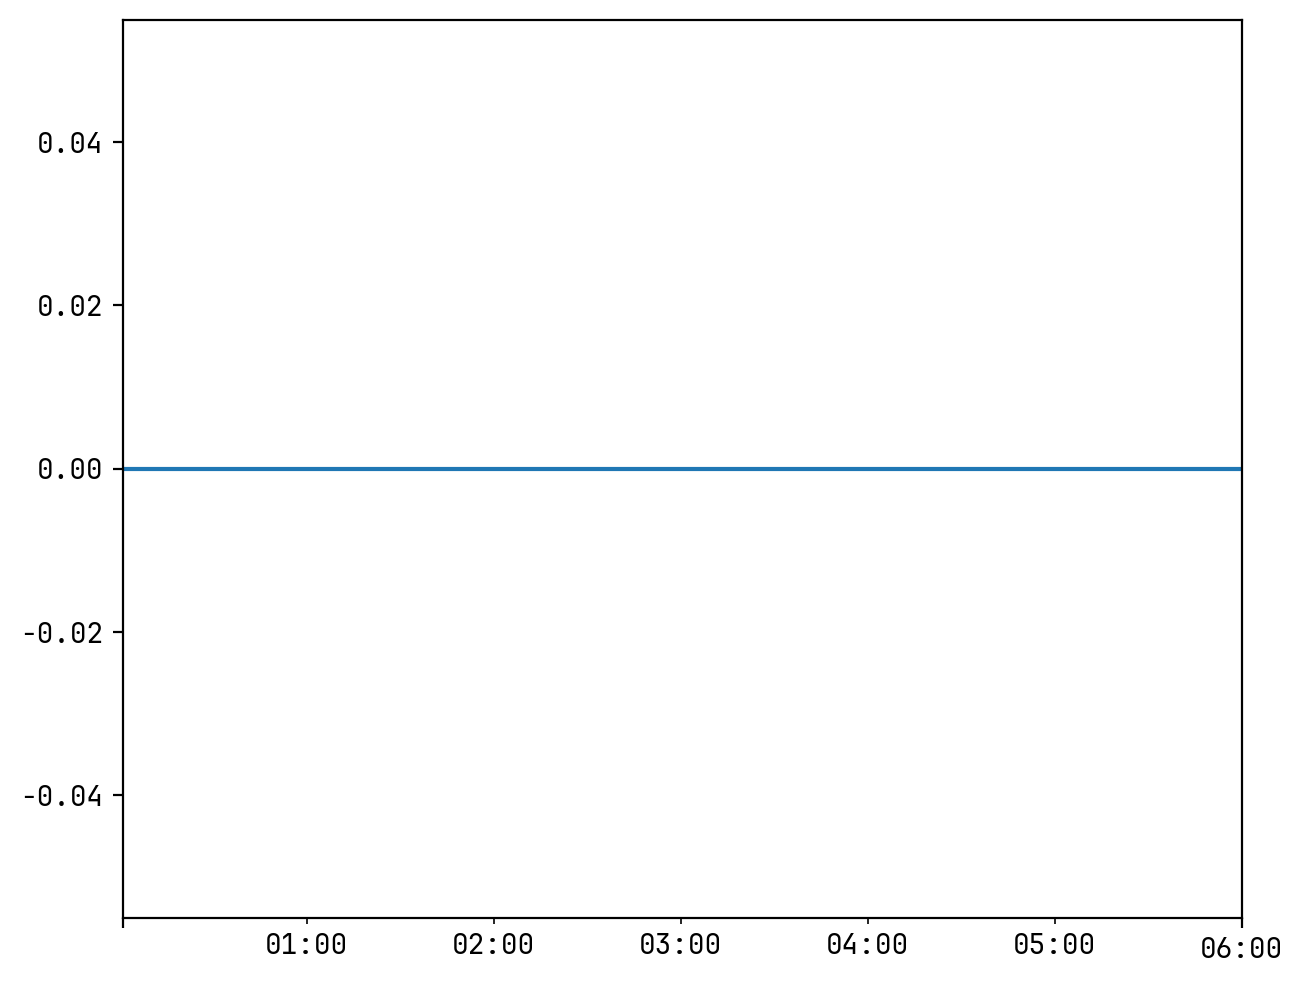

In [12]:
out.get_part(OBJECTS.SYSTEM, None, VARIABLES.SYSTEM.FLOODING).plot()

(<Figure size 1280x960 with 1 Axes>, <Axes: >)

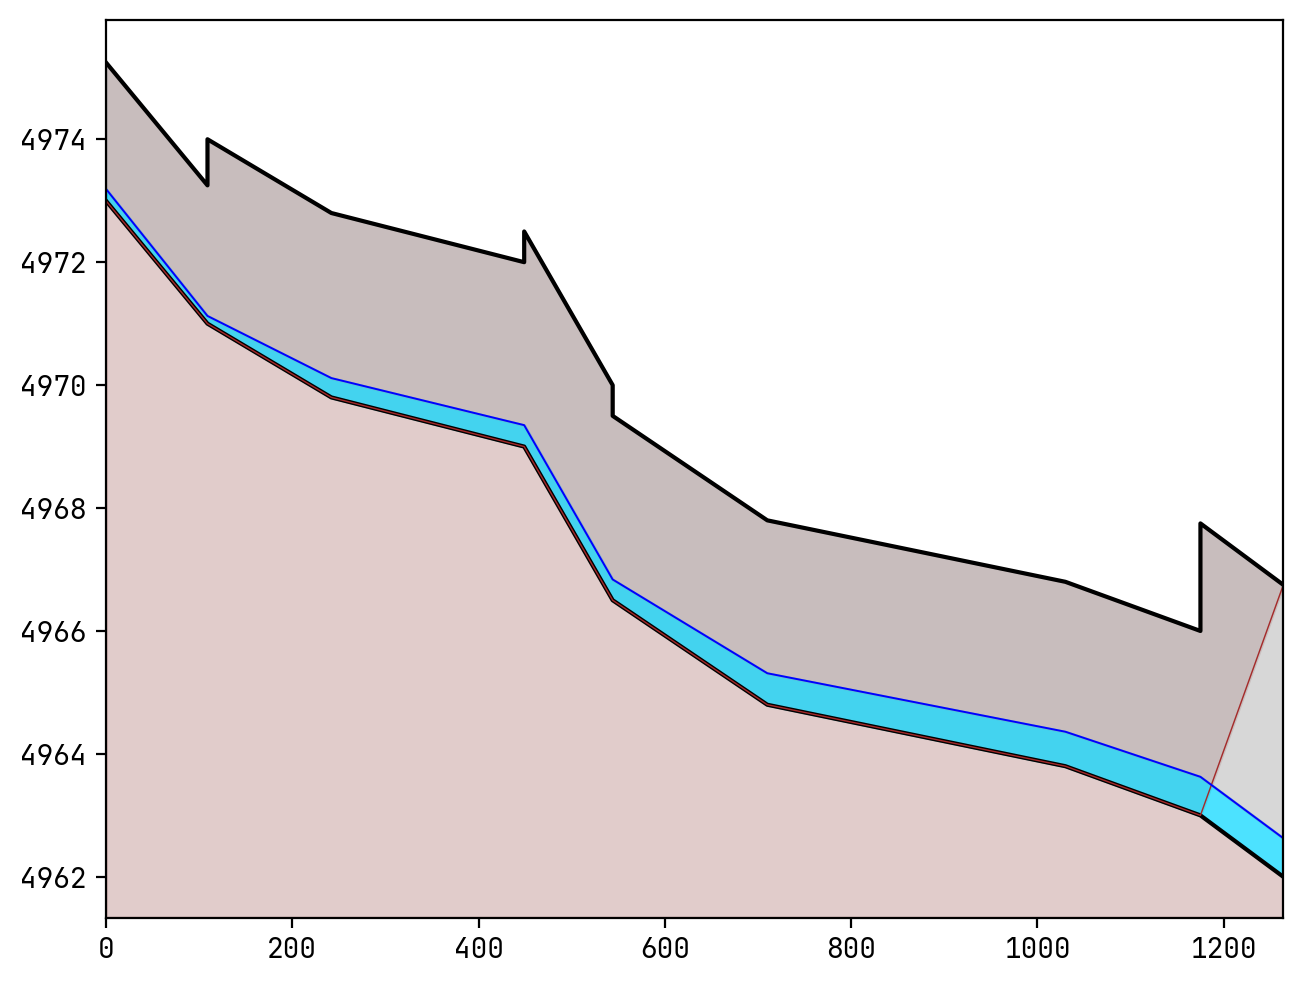

In [13]:
from swmm_api.input_file.macros.plotting_longitudinal import plot_longitudinal

plot_longitudinal(inp, 'J3', 'O1', out, depth_agg_func=lambda x: x.loc['1998-01-01 01:00'])

### 6. 

Select a different return period storm for the Rain Gage and see how it affects runoff hydrographs and TSS pollutographs.

<Axes: >

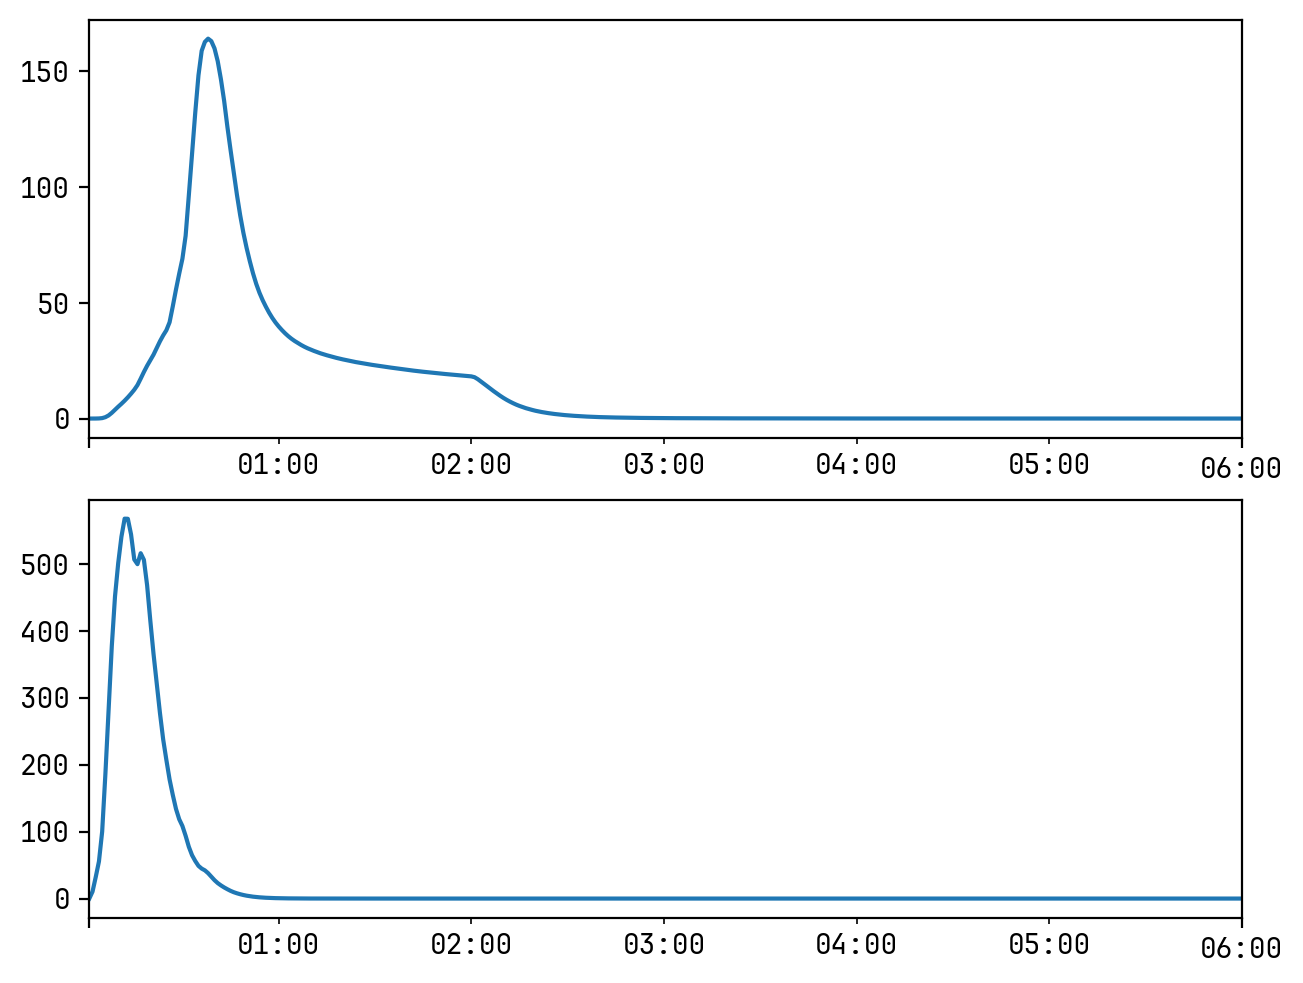

In [14]:
inp.RAINGAGES['RainGage'].timeseries = '100-yr'

with swmm5_run_temporary(inp.copy(), run=swmm5_run_epa, label='example_run_swmm') as res:
    out = res.out  # type: SwmmOutput
    rpt = res.rpt  # type: SwmmReport

# ---
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(nrows=2)
out.get_part(OBJECTS.NODE, 'O1', VARIABLES.NODE.TOTAL_INFLOW).plot(ax=ax1)
out.get_part(OBJECTS.NODE, 'O1', out.labels['pollutant']).plot(ax=ax2)

### 7. 

Modify the model to run a continuous simulation as follows:
   
   1) Edit the rain gage and change its Data Source to File, click
      on the File Name field and specify the rain data file named 
      sta310301.dat, and enter 310301 for the Station Number.
   2) Edit the Simulation Options as follows:

      1. change the Routing Method back to Kinematic Wave
      2. make the End Date 01-02-2000 (for a 2-year simulation)
      3. change the Routing Time Step to 5 minutes.

In [15]:
inp.RAINGAGES

{   'RainGage': RainGage(name='RainGage', form='INTENSITY', interval='0:05', SCF=1.0, source='TIMESERIES', timeseries='100-yr', filename=nan, station=nan, units=nan)}

In [16]:
print(inp.OPTIONS.to_inp_lines())

FLOW_UNITS           CFS
INFILTRATION         HORTON
FLOW_ROUTING         DYNWAVE
LINK_OFFSETS         DEPTH
MIN_SLOPE            0
ALLOW_PONDING        NO
SKIP_STEADY_STATE    NO
START_DATE           01/01/1998
START_TIME           00:00:00
REPORT_START_DATE    01/01/1998
REPORT_START_TIME    00:00:00
END_DATE             01/01/1998
END_TIME             06:00:00
SWEEP_START          01/01
SWEEP_END            12/31
DRY_DAYS             5
REPORT_STEP          00:01:00
WET_STEP             00:01:00
DRY_STEP             01:00:00
ROUTING_STEP         0:00:15
RULE_STEP            00:00:00
INERTIAL_DAMPING     PARTIAL
NORMAL_FLOW_LIMITED  SLOPE
FORCE_MAIN_EQUATION  H-W
VARIABLE_STEP        0.75
LENGTHENING_STEP     0
MIN_SURFAREA         12.566
MAX_TRIALS           8
HEAD_TOLERANCE       0.005
SYS_FLOW_TOL         5
LAT_FLOW_TOL         5
MINIMUM_STEP         0.5
THREADS              1


In [17]:
import numpy as np

inp.RAINGAGES['RainGage'].source = 'FILE'
inp.RAINGAGES['RainGage'].timeseries = np.nan
inp.RAINGAGES['RainGage'].filename = 'sta310301.dat'
inp.RAINGAGES['RainGage'].station = '310301'
inp.RAINGAGES['RainGage'].units = 'MM'

inp.OPTIONS['FLOW_ROUTING'] = 'KINWAVE'
inp.OPTIONS['END_DATE'] = '01/02/2000'
inp.OPTIONS['ROUTING_STEP'] = 300
inp.OPTIONS['REPORT_STEP'] = pd.Timedelta(seconds=300).to_pytimedelta()

### 8.

Run the simulation (it may take several minutes). Try generating a Statistics Report to see how the magnitude of various kinds of events (rainfall, runoff, quality, etc.) are distributed over time.

In [18]:
with swmm5_run_temporary(inp.copy(), run=swmm5_run_progress, label='example_run_swmm') as res:
    rpt = res.rpt  # type: SwmmReport
    out = res.out  # type: SwmmOutput

swmm5 /var/folders/3v/lct6k8mn02xdl7r3zg30bjl00000gn/T/tmp4p1kguy0/example_run_swmm.inp:   0%|          | 0/10…

In [19]:
rpt.print_raw_part('Runoff Quantity Continuity')
print('='*60)
rpt.print_raw_part('Runoff Quality Continuity')

  **************************        Volume         Depth
  Runoff Quantity Continuity     acre-feet        inches
  **************************     ---------       -------
  Total Precipitation ......       158.506        65.770
  Evaporation Loss .........         0.000         0.000
  Infiltration Loss ........        67.584        28.043
  Surface Runoff ...........        90.870        37.706
  Final Storage ............         0.062         0.026
  Continuity Error (%) .....        -0.007
  **************************           TSS
  Runoff Quality Continuity            lbs
  **************************    ----------
  Initial Buildup ..........       913.850
  Surface Buildup ..........     13187.087
  Wet Deposition ...........         0.000
  Sweeping Removal .........         0.000
  Infiltration Loss ........         0.000
  BMP Removal ..............         0.000
  Surface Runoff ...........     12916.203
  Remaining Buildup ........      1184.734
  Continuity Error (%) .....

In [20]:
out.index.freq

<5 * Minutes>

In [21]:
out.flow_unit

'CFS'

In [22]:
from swmm_api.output_file.analysis import get_event_table, agg_events
import pandas as pd

p = out.get_part(OBJECTS.SYSTEM, None, VARIABLES.SYSTEM.RAINFALL)  # unit is in/hr

events = get_event_table(p>0, delta_separation=pd.Timedelta(hours=6))
events['total rainfall'] = agg_events(events, p, 'sum') # only sums values - units must be checks and converted accordingly
events['peak rainfall'] = agg_events(events, p, 'max')
events

start                 end        duration  total rainfall  \
0   1998-01-06 04:00:00 1998-01-06 05:55:00 0 days 01:55:00        0.240000   
1   1998-01-07 03:00:00 1998-01-08 02:55:00 0 days 23:55:00       40.200001   
2   1998-01-11 17:00:00 1998-01-11 18:55:00 0 days 01:55:00        0.240000   
3   1998-01-14 23:00:00 1998-01-15 17:55:00 0 days 18:55:00       11.279999   
4   1998-01-16 08:00:00 1998-01-16 13:55:00 0 days 05:55:00        6.960000   
..                  ...                 ...             ...             ...   
208 1999-12-06 16:00:00 1999-12-06 16:55:00 0 days 00:55:00        0.120000   
209 1999-12-10 06:00:00 1999-12-10 07:55:00 0 days 01:55:00        2.160000   
210 1999-12-12 23:00:00 1999-12-13 11:55:00 0 days 12:55:00        7.920000   
211 1999-12-21 05:00:00 1999-12-21 07:55:00 0 days 02:55:00        1.560000   
212 1999-12-21 14:00:00 1999-12-21 15:55:00 0 days 01:55:00        0.720000   

     peak rainfall  
0             0.01  
1             0.50  
2             0.01  
3             0.10  
4             0.28  
..             ...  
208           0.01  
209           0.10  
210           0.20  
211           0.07  
212           0.04  

[213 rows x 5 columns]

In [23]:
p.resample('D').sum().sort_values(ascending=False)

1998-01-07    37.200001
1998-04-19    21.960000
1998-01-27    21.840000
1999-11-25    20.520000
1999-01-02    19.320000
                ...    
1998-10-25     0.000000
1998-10-26     0.000000
1998-10-27     0.000000
1998-10-28     0.000000
2000-01-02     0.000000
Name: system//rainfall, Length: 732, dtype: float64